# Assigning the lpGBTs to the Slinks

Main boundary conditions:
- Done per 120-degree sector.
- Each 120-degree sector has 28 FPGAs.
- Each FPGA has either:
  - 12× 16G Slink outputs => 336 Slink outputs, or
  - 8× 25G Slink outputs => 224 Slink outputs.

One idea:
- Straddling ECONDs imply that an lpGBT pair is the quantum of the system.
- Single lpGBTs need to be paired:
  - Sort their rates and then take largest and smallest in pairs.
- Pairs of lpGBTs are then assigned to individual Slinks:
  - Max of 8 lpGBT pairs per Slink.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 144

In [2]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')

In [3]:
linkRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,12,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
1,13,240.2424,7.0,1,3.333333,4.666667,314.0,3,False,7.687757,1098.250971
2,14,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,15,142.2112,5.0,1,6.500000,6.500000,366.5,4,False,4.550758,910.151680
4,16,176.1495,6.0,1,7.000000,6.000000,374.0,5,False,5.636784,939.464000
...,...,...,...,...,...,...,...,...,...,...,...
105,894,157.3610,8.0,29,2.333333,3.666667,7465.0,3,True,5.035552,629.444000
106,907,186.1277,8.0,30,4.000000,2.000000,7746.0,3,True,5.956086,744.510800
107,920,170.0694,9.0,30,1.000000,4.000000,7700.0,3,True,5.442221,604.691200
108,922,169.7657,9.0,30,3.000000,4.000000,7732.0,3,True,5.432502,603.611378


In [4]:
linkRates.describe()

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,EvSize [kb],BitsPerElink
count,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000,1398.000000
mean,787.293276,109.937597,5.218169,25.790415,6.280365,4.876753,6707.708798,3.469957,3.518003,634.475326
std,428.026769,85.778683,2.085581,13.823449,4.051449,2.920843,3564.675649,1.475701,2.744918,264.789423
min,0.000000,12.189000,1.000000,1.000000,0.000000,0.000000,275.000000,1.000000,0.390048,78.009600
25%,436.500000,55.834265,4.000000,15.000000,3.000000,2.500000,3861.250000,3.000000,1.786696,497.917360
50%,790.500000,90.116900,5.000000,26.000000,5.500000,4.666667,6710.000000,4.000000,2.883741,616.400933
75%,1157.750000,134.574200,6.000000,38.000000,8.000000,7.500000,9764.500000,5.000000,4.306374,829.407200
max,1507.000000,483.269900,14.000000,50.000000,15.000000,13.000000,13051.000000,6.000000,15.464637,1312.124800


In [5]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")


There is a total of 1508 lpGBT links:
 - 1288 singles, and
 - 110 doubles (with one ECOND straddling the pair)



In [6]:
sortedSinglesRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')

In [7]:
assert( len(sortedSinglesRates)%2 == 0 )

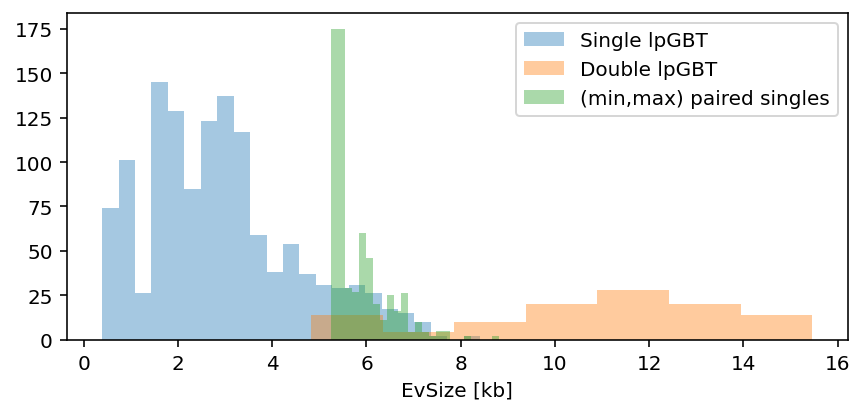

In [8]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    linkRates[ ~linkRates.doubleDAQlpGBT ]['EvSize [kb]'],
    kde=False,
    label='Single lpGBT'
    )
sns.distplot(
    linkRates[ linkRates.doubleDAQlpGBT ]['EvSize [kb]'],
    kde=False,
    label='Double lpGBT'
    )
sns.distplot(
    [ sortedSinglesRates.iloc[[i,-i-1]]['EvSize [kb]'].sum() for i in range(int(len(sortedSinglesRates)/2)) ],
    #axlabel='EvSize [kb] per naively-paired single lpGBTs',
    kde=False,
    label='(min,max) paired singles'
    )
plt.legend()

Since there are singles with larger rates than some doubles, the naive pairing of singles need not be a good idea.

In [9]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)

## Trying a simple/greedy packing algorithm

Main idea:
- Start with N_Slink group seeds using the N_Slink largest-rate lpGBTs.
- Add the next largest lpGBT to the Slink with the smallest total rate.

This should also work when instead of averages we use something like the 90th centile of the lpGBT event size distributions.

In [10]:
nSlinks = 336 # 16G
# nSlinks = 224 # 25G

In [11]:
sortedLinkRates = linkRates.sort_values(by=['EvSize','nModules'], ascending=False)[['DAQlpGBT','EvSize','nDAQlpGBT','doubleDAQlpGBT']]

In [12]:
sortedLinkRates

,DAQlpGBT,EvSize,nDAQlpGBT,doubleDAQlpGBT
25,126,483.2699,2,True
24,124,483.2248,2,True
12,60,467.6358,2,True
13,62,467.5174,2,True
40,192,461.9141,2,True
...,...,...,...,...
1164,1384,12.1992,1,False
1159,1379,12.1976,1,False
1162,1382,12.1958,1,False
1160,1380,12.1951,1,False


In [13]:
avSlinkEvSize = sortedLinkRates['EvSize'].sum()/nSlinks

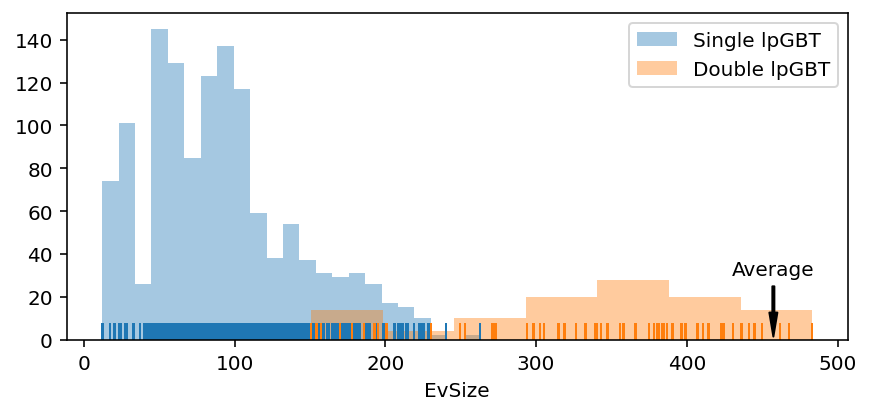

In [14]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    sortedLinkRates[ ~sortedLinkRates.doubleDAQlpGBT ]['EvSize'],
    kde=False,
    rug=True,
    label='Single lpGBT'
    )
plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
sns.distplot(
    sortedLinkRates[ sortedLinkRates.doubleDAQlpGBT ]['EvSize'],
    kde=False,
    rug=True,
    label='Double lpGBT'
    )
plt.legend()

In [15]:
sortedLinkRates[ sortedLinkRates.EvSize >= avSlinkEvSize ]

,DAQlpGBT,EvSize,nDAQlpGBT,doubleDAQlpGBT
25,126,483.2699,2,True
24,124,483.2248,2,True
12,60,467.6358,2,True
13,62,467.5174,2,True
40,192,461.9141,2,True
41,194,461.5940,2,True


In [16]:
from dataclasses import dataclass
@dataclass
class Slink:
    totalEvSize: float
    linkList: list

from operator import attrgetter
def assign_link(link, Slinks):
    Slinks.sort(key=attrgetter('totalEvSize'))
    target = Slinks[0]
    # print(f'{link.EvSize} -> {Slinks[0].totalEvSize}')
    target.linkList.append(link)
    target.totalEvSize += link.EvSize
    return Slinks

Slinks = [Slink(totalEvSize=0, linkList=[]) for _ in range(nSlinks)]

for link in sortedLinkRates.itertuples(name='Link', index=False):
    Slinks = assign_link(link, Slinks)

In [17]:
SlinkTotals = pd.DataFrame(data=[ Slink.totalEvSize for Slink in Slinks ], columns=['EvSize'])

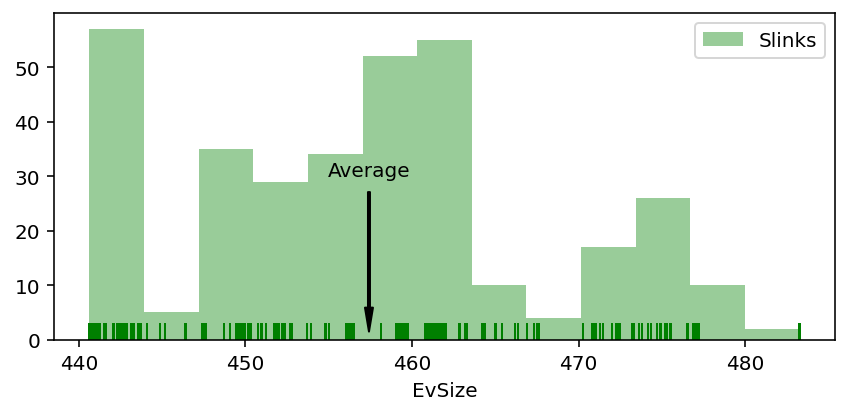

In [18]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    SlinkTotals['EvSize'],
    kde=False,
    rug=True,
    color = 'g',
    label='Slinks'
    )
plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
plt.legend()

In [19]:
SlinkTotals.describe()

,EvSize
count,336.000000
mean,457.418931
std,10.396566
min,440.636100
25%,449.694400
50%,459.246260
75%,461.902583
max,483.269900


In [20]:
print(f'RMS/mean = {float(SlinkTotals.std()/SlinkTotals.mean()):.2%}')

RMS/mean = 2.27%


### Swaps

Can the naive solution above be improved into a better one with a smaller RMS?

Two things to try:
- Moving the smallest lpGBT from a big Slink to a smaller Slink (spoiler alert: not possible)
- Swap lpGBTS between Slinks in such a way that Slink sizes are closer together (smaller RMS)

In [21]:
sortedSlinks = sorted(Slinks, key=attrgetter('totalEvSize'))

import itertools as it
SlinkPairs = tuple(it.combinations(sortedSlinks, 2))

In [22]:
for i, (small, big) in enumerate(SlinkPairs[10000:12000]):

    # Assume that the pairs are ordered with the first element bing the biggest Slink
    diffOrig = big.totalEvSize - small.totalEvSize
    assert(diffOrig > 0)

    # It seems that the difference between Slinks is always smaller than the smallest Slink input rate.
    # I was not expecting this. It may be a feature of the naive assignment algorithm.
    min_big = min(big.linkList, key=attrgetter('EvSize'))
    assert(min_big.EvSize > diffOrig)

In [23]:
for i, (small, big) in enumerate(SlinkPairs[10000:12000]):

    # Assume that the pairs are ordered with the first element bing the biggest Slink
    diffOrig = big.totalEvSize - small.totalEvSize
    assert(diffOrig > 0)

    print(f'''{i}:
    Big:    {big}
    Small:  {small}

--> (big-small) = {diffOrig:>+8.3f}
    ''')

    # bigAfter   = big.totalEvSize   -min_big.EvSize
    # smallAfter = small.totalEvSize +min_big.EvSize
    # diffAfter = bigAfter - smallAfter
    # print(f' (big-small)\' = {diffAfter:>+8.3f} <== {min_big.DAQlpGBT:4d} --> ()')

    # So, let's consider swapping inputs instead of moving inputs
    # Build all the input rate differences that can lead to a better balancing via swaps of inputs between the Slinks
    for bigLink, smallLink in it.product(big.linkList, small.linkList):
        bigAfter   = big.totalEvSize   -bigLink.EvSize +smallLink.EvSize
        smallAfter = small.totalEvSize +bigLink.EvSize -smallLink.EvSize
        diffAfter = bigAfter - smallAfter
        if(abs(diffAfter)<abs(diffOrig)):
            print(f' {bigLink.DAQlpGBT:4d} <-> {smallLink.DAQlpGBT:4d} ==> (big-small)\' = {diffAfter:>+8.3f}')
    
    print()

(big-small) =  +28.231
    

1977:
    Big:    Slink(totalEvSize=471.04819999999995, linkList=[Link(DAQlpGBT=374, EvSize=347.669, nDAQlpGBT=2, doubleDAQlpGBT=True), Link(DAQlpGBT=1123, EvSize=75.6387, nDAQlpGBT=1, doubleDAQlpGBT=False), Link(DAQlpGBT=569, EvSize=47.7405, nDAQlpGBT=1, doubleDAQlpGBT=False)])
    Small:  Slink(totalEvSize=442.79560000000004, linkList=[Link(DAQlpGBT=78, EvSize=159.3039, nDAQlpGBT=1, doubleDAQlpGBT=False), Link(DAQlpGBT=1101, EvSize=118.5527, nDAQlpGBT=1, doubleDAQlpGBT=False), Link(DAQlpGBT=864, EvSize=92.4788, nDAQlpGBT=1, doubleDAQlpGBT=False), Link(DAQlpGBT=619, EvSize=72.4602, nDAQlpGBT=1, doubleDAQlpGBT=False)])

--> (big-small) =  +28.253
    
 1123 <->  619 ==> (big-small)' =  +21.896

1978:
    Big:    Slink(totalEvSize=471.26130000000006, linkList=[Link(DAQlpGBT=234, EvSize=249.5858, nDAQlpGBT=2, doubleDAQlpGBT=True), Link(DAQlpGBT=645, EvSize=99.3158, nDAQlpGBT=1, doubleDAQlpGBT=False), Link(DAQlpGBT=650, EvSize=74.6571, nDAQlpGBT=1, doubleDAQlp

Text(0.5, 0, 'lpGBT/Slink')

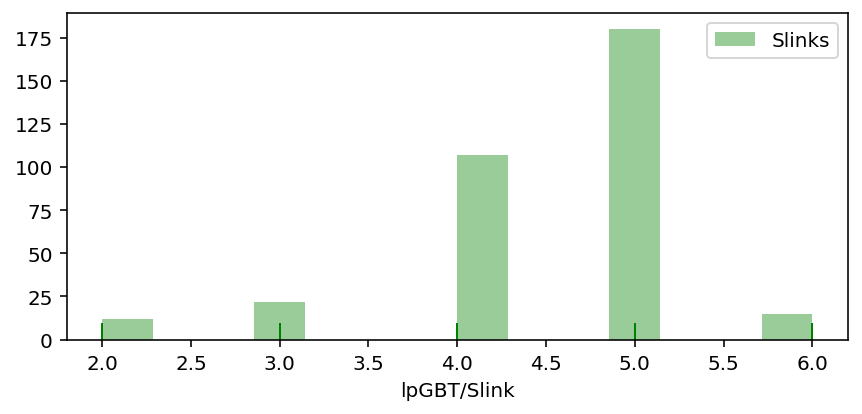

In [24]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    [ sum([link.nDAQlpGBT for link in Slink.linkList]) for Slink in Slinks ],
    kde=False,
    rug=True,
    color = 'g',
    label='Slinks'
    )
plt.legend()
plt.xlabel('lpGBT/Slink')